In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr
from scipy import stats
import warnings
from scipy.signal import argrelextrema
from cydets.algorithm import detect_cycles
import os 
import openpyxl

import statsmodels

In [59]:
curr_path = os.getcwd()
input_path = os.path.join(curr_path,'merged_data.xlsx')

data = pd.read_excel(
    input_path,
    engine='openpyxl',
)

# drop unnecessary columns
data.drop(['SP500-PE', 'SP500-Price', 'SP500-EPS', 'EPS-GR', 'Date'], axis=1, inplace=True)

# rename column
data.rename(columns={"IPMAN": "IndustrialProduction", "AMTMNO": "ManufacturingNewOrders", "LES1252881600Q":"MedianUsualWeeklyRealEarnings", "PPIACO": "PPI", "TTLCONS":"ConstructionSpending", "SLRTO01USQ6575": "VolumeOfTotalRetailTradeSales"}, inplace=True)

## Calculate Required Sample Size

In [60]:
effect_size = 0.5
alpha = 0.05 # significance level
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size: {0:.2f}'.format(sample_size))

Required sample size: 63.77


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SP500-Index                    620 non-null    float64
 1   gdp                            206 non-null    float64
 2   IndustrialProduction           591 non-null    float64
 3   GS10                           620 non-null    float64
 4   ManufacturingNewOrders         350 non-null    float64
 5   CPIFABSL                       620 non-null    float64
 6   MedianUsualWeeklyRealEarnings  169 non-null    float64
 7   PCE                            620 non-null    float64
 8   PPI                            620 non-null    float64
 9   ConstructionSpending           339 non-null    float64
 10  SLRTTO01USQ657S                195 non-null    float64
 11  HousingSales                   620 non-null    int64  
 12  UnemploymentRate               620 non-null    flo

## Correlation Matrix

In [47]:
data.corr(method='pearson')

,SP500-Index,gdp,IPMAN,GS10,AMTMNO,CPIFABSL,LES1252881600Q,PCE,PPIACO,TTLCONS,SLRTTO01USQ657S,HousingSales,UnemploymentRate
SP500-Index,1.000000,0.934687,0.835399,-0.749587,0.884022,0.889952,0.736581,0.932967,0.879402,0.774313,-0.000709,0.927242,-0.244431
gdp,0.934687,1.000000,0.929690,-0.823701,0.906554,0.984319,0.827368,0.999619,0.959268,0.887066,-0.041341,0.991539,-0.142689
IPMAN,0.835399,0.929690,1.000000,-0.818785,0.869800,0.940962,0.680835,0.928826,0.913860,0.781537,-0.031288,0.927568,-0.346233
GS10,-0.749587,-0.823701,-0.818785,1.000000,-0.821421,-0.774962,-0.752117,-0.828498,-0.705310,-0.742600,-0.094128,-0.798233,0.233989
AMTMNO,0.884022,0.906554,0.869800,-0.821421,1.000000,0.906494,0.615340,0.909989,0.950812,0.758139,-0.188104,0.880686,-0.025253
CPIFABSL,0.889952,0.984319,0.940962,-0.774962,0.906494,1.000000,0.791676,0.982271,0.984427,0.833358,-0.051069,0.981026,-0.105771
LES1252881600Q,0.736581,0.827368,0.680835,-0.752117,0.615340,0.791676,1.000000,0.823982,0.717912,0.851960,-0.012908,0.825477,-0.090303
PCE,0.932967,0.999619,0.928826,-0.828498,0.909989,0.982271,0.823982,1.000000,0.958123,0.883970,-0.042719,0.990628,-0.160059
PPIACO,0.879402,0.959268,0.913860,-0.705310,0.950812,0.984427,0.717912,0.958123,1.000000,0.720409,-0.078594,0.954926,-0.030046
TTLCONS,0.774313,0.887066,0.781537,-0.742600,0.758139,0.833358,0.851960,0.883970,0.720409,1.000000,-0.243934,0.927093,-0.187143


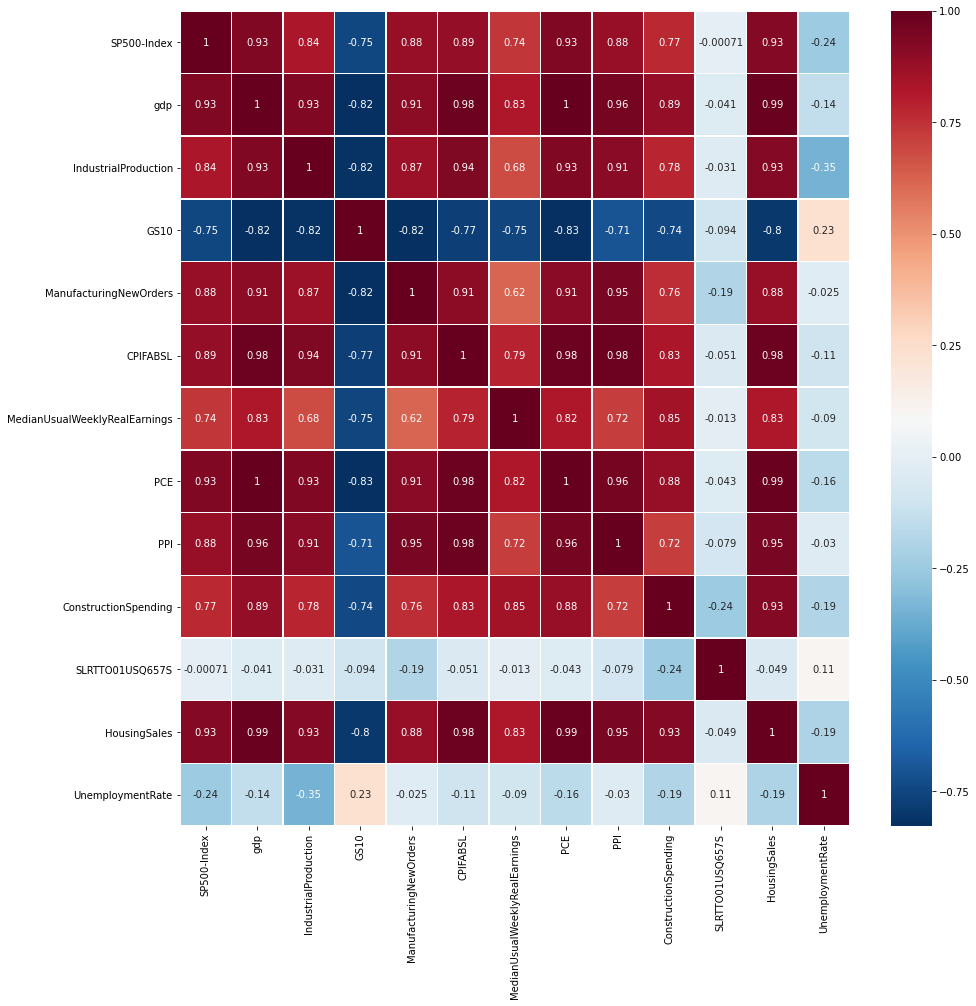

In [55]:
# use all features
plt.figure(figsize = (15,15))
pearsoncorr = data.corr(method='pearson')
sns.heatmap(pearsoncorr,
xticklabels=pearsoncorr.columns,
yticklabels=pearsoncorr.columns,
cmap='RdBu_r',
annot=True,
linewidth=0.5)
plt.show()

## OLS

In [62]:
# drop na
data.dropna(inplace=True)

# normalize all columns
normalized_data=(data-data.mean())/data.std()

X = normalized_data.drop(['SP500-Index'], axis=1)
y = normalized_data['SP500-Index']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:            SP500-Index   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                              177.8
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                    3.66e-57
Time:                        22:45:35   Log-Likelihood:                          19.328
No. Observations:                 102   AIC:                                     -14.66
Df Residuals:                      90   BIC:                                      16.84
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

## Co-Integration Test

In [64]:
res = statsmodels.tsa.stattools.coint(data_small['GS10'], data_small['CPIFABSL'], trend='c', method='aeg', maxlag=None, autolag='aic', return_results=None)
print(f'p-value: {res[1]}')

p-value: 0.22094845475831354
